<a href="https://colab.research.google.com/github/osmarbraz/coebert/blob/main/GerarDadosValidacaoKfold_CSTNews_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gerar 10 folds para validação cruzada do conjunto de dados CStNews

Divide os dados do Sumários Multidocumentos baseados no CSTNews 5.0 em 10 folds.

Cada fold possui 90% para dados de treinamento e 10% para dados de teste.

Os dados de teste não se repetem em cada fold.

O procedimento exclui os documentos que geram mais de 512 tokens.

----------------------------
**CSTNews 5.0:** https://sites.icmc.usp.br/taspardo/sucinto/files/CSTNews%205.0.zip

**Trabalho Marcio Dias:** https://sites.icmc.usp.br/taspardo/Summary%20coherence%20models.zip

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers


**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento
inicioProcessamento = time.time()

## 1.2 Funções e classes auxiliares

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas
import time
import datetime

def formataTempo(tempo):
    '''
    Pega a tempo em segundos e retorna uma string hh:mm:ss
    '''
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModelArguments:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    fold: int = field(
        default="1",
        metadata={"help": "quantidade de folds a serem gerados"},
    )

Remove tags de um documento(texto)

In [ ]:
def remove_tags(documento):
    """Remove tags de um documento(texto)"""
    
    import re

    documentoLimpo = re.compile('<.*?>')
    return re.sub(documentoLimpo, '', documento)

Funções auxiliares de arquivos

In [ ]:
# Gera um paragráfo com as linhas do arquivo especificado
def carregar(nomeArquivo):
    """Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto)"""

    # Linha anterior    
    arquivo = open(nomeArquivo, 'r')
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = ' '.join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    arquivo.close()
    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

# Gera uma lista das linhas do arquivo especificado
def carregarLista(nomeArquivo):
    """Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto)"""

    # Linha anterior    
    arquivo = open(nomeArquivo, 'r')
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = ' '.join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    arquivo.close()
    return sentencas    

def salvar(nomeArquivo,texto):                       
    """Salva um texto em um arquivo"""

    arquivo = open(nomeArquivo, 'w')
    arquivo.write(str(texto))
    arquivo.close()

## 1.3 Tratamento de logs

In [ ]:
# Biblioteca de logging
import logging

# Formatando a mensagem de logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Se estiver executando no Google Colaboratory
import sys

# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = 'google.colab' in sys.modules

## 1.5 Biblioteca de limpeza de tela

In [ ]:
from IPython.display import clear_output

## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount('/content/drive')     

Mounted at /content/drive


## 1.7 Instalação BERT da Hugging Face

Instala a interface pytorch para o BERT by Hugging Face. 

In [ ]:
!pip install -U transformers==4.5.1

     |████████████████████████████████| 2.1MB 2.8MB/s 
     |████████████████████████████████| 870kB 18.0MB/s 
     |████████████████████████████████| 3.3MB 16.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=73127e8db52845aa5c1c917cbaf377c681b399f16911d0514d887a1ae7298058
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


## 1.8 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Importando a biblioteca
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == '/device:GPU:0':
    print('Encontrei GPU em: {}'.format(device_name))
else:
    print('Dispositivo GPU não encontrado')
    #raise SystemError('Dispositivo GPU não encontrado')

Encontrei GPU em: /device:GPU:0


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Importando a biblioteca
import torch

# Se existe GPU disponível...
if torch.cuda.is_available():    

    # Diz ao PyTorch para usar GPU.    
    device = torch.device("cuda")

    print('Existem {} GPU(s) disponíveis.'.format(torch.cuda.device_count()))

    print('Iremos usar a GPU: {}'.format(torch.cuda.get_device_name(0)))

# Se não...
else:
    print('Sem GPU disponível, usando CPU.')
    device = torch.device("cpu")

Existem 1 GPU(s) disponíveis.
Iremos usar a GPU: Tesla P100-PCIE-16GB


Memória

Memória disponível no ambiente

In [ ]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n'.format(ram_gb))

if ram_gb < 20:
  print('Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"')
  print('e selecione High-RAM. Então, execute novamente está célula')
else:
  print('Você está usando um ambiente de execução de memória RAM alta!')

# 2 Parametrização

In [ ]:
# Definição dos parâmetros do Modelo
model_args = ModelArguments(     
    max_seq_len = 512,
    pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",    
    #pretrained_model_name_or_path = 'bert-base-multilingual-cased',
    do_lower_case = False,
    output_hidden_states = False,
    fold = 10 # Quantidade folds a ser gerado
)

# 3 Download do arquivo do PyTorch Checkpoint

Lista de modelos da comunidade:
* https://huggingface.co/models

Português(https://github.com/neuralmind-ai/portuguese-bert):  
* **'neuralmind/bert-base-portuguese-cased'**
* **'neuralmind/bert-large-portuguese-cased'**

In [ ]:
# Importando as bibliotecas.
import os

# Variável para setar o arquivo.
URL_MODELO = None

if 'http' in model_args.pretrained_model_name_or_path:
  URL_MODELO = model_args.pretrained_model_name_or_path

# Se a variável foi setada.
if URL_MODELO:

    # Diretório descompactação.
    DIRETORIO_MODELO = '/content/modelo'

    # Recupera o nome do arquivo do modelo da url.
    arquivo = URL_MODELO.split("/")[-1]

    # Nome do arquivo do vocabulário.
    arquivo_vocab = "vocab.txt"

    # Caminho do arquivo na url.
    caminho = URL_MODELO[0:len(URL_MODELO)-len(arquivo)]

     # Verifica se a pasta de descompactação existe na pasta corrente
    if os.path.exists(DIRETORIO_MODELO):
      print("Apagando diretório existente do modelo!")
      # Apaga a pasta e os arquivos existentes
      !rm -rf $DIRETORIO_MODELO  
   
    # Baixa o arquivo do modelo.
    !wget $URL_MODELO
    
    # Descompacta o arquivo na pasta de descompactação.
    !unzip -o $arquivo -d $DIRETORIO_MODELO

    # Baixa o arquivo do vocabulário
    # O vocabulário não está no arquivo compactado acima, mesma url mas arquivo diferente.
    URL_MODELO_VOCAB = caminho + arquivo_vocab
    !wget $URL_MODELO_VOCAB
    
    # Coloca o arquivo do vocabulário no diretório de descompactação.
    !mv $arquivo_vocab $DIRETORIO_MODELO
            
    # Move o arquivo para pasta de descompactação.
    !mv $arquivo $DIRETORIO_MODELO
       
    print('Pasta do {} pronta!'.format(DIRETORIO_MODELO))

    # Lista a pasta corrente
    !ls -la $DIRETORIO_MODELO
else:
    print('Variável URL_MODELO não setada!')

--2021-04-15 19:57:47--  https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip
Resolving neuralmind-ai.s3.us-east-2.amazonaws.com (neuralmind-ai.s3.us-east-2.amazonaws.com)... 52.219.98.194
Connecting to neuralmind-ai.s3.us-east-2.amazonaws.com (neuralmind-ai.s3.us-east-2.amazonaws.com)|52.219.98.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1244275810 (1.2G) [application/zip]
Saving to: ‘bert-large-portuguese-cased_pytorch_checkpoint.zip’

bert-large-portugue 100%[===================>]   1.16G  16.5MB/s    in 74s     

2021-04-15 19:59:01 (16.1 MB/s) - ‘bert-large-portuguese-cased_pytorch_checkpoint.zip’ saved [1244275810/1244275810]

Archive:  bert-large-portuguese-cased_pytorch_checkpoint.zip
  inflating: /content/modelo/config.json  
  inflating: /content/modelo/pytorch_model.bin  
--2021-04-15 19:59:17--  https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-port

# 4 Carregando o Tokenizador(tokenizer) BERT

O tokenizador utiliza WordPiece, veja em [artigo original](https://arxiv.org/pdf/1609.08144.pdf).

Carregando o tokenizador da pasta '/content/modelo/' do diretório padrão se variável `URL_MODELO` setada.

**Caso contrário carrega da comunidade**

Por default(`do_lower_case=True`) todas as letras são colocadas para minúsculas. Para ignorar a conversão para minúsculo use o parâmetro `do_lower_case=False`. Esta opção também considera as letras acentuadas(ãçéí...), que são necessárias a língua portuguesa.

In [ ]:
# Importando as bibliotecas do tokenizador.
from transformers import BertTokenizer

# Se a variável URL_MODELO foi setada.
if URL_MODELO:
    # Carregando o Tokenizador.
    print('Carrgando o tokenizador BERT do diretório {}...'.format(DIRETORIO_MODELO))

    tokenizer = BertTokenizer.from_pretrained(DIRETORIO_MODELO, 
                                              do_lower_case=model_args.do_lower_case)    
else:
    # Carregando o Tokenizador da comunidade.
    print('Carregando o tokenizador da comunidade...')
    
    tokenizer = BertTokenizer.from_pretrained(model_args.pretrained_model_name_or_path, 
                                              do_lower_case=model_args.do_lower_case)

Carrgando o tokenizador BERT do diretório /content/modelo...


# 5 Carregando o Modelo(model) BERT

Se a variável `URL_MODELO` estiver setada carrega o modelo do diretório `content/modelo`.

Caso contrário carrega da comunidade.

Carregando o modelo da pasta '/content/modelo/' do diretório padrão.

A implementação do huggingface pytorch inclui um conjunto de interfaces projetadas para uma variedade de tarefas de PNL. Embora essas interfaces sejam todas construídas sobre um modelo treinado de BERT, cada uma possui diferentes camadas superiores e tipos de saída projetados para acomodar suas tarefas específicas de PNL.

A documentação para estas pode ser encontrada em [aqui](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).

Por default o modelo está em modo avaliação ou seja `model.eval()`.

-----------------------

Durante a avaliação do modelo, este retorna um número de diferentes objetos com base em como é configurado na chamada do método `from_pretrained`. 

Quando definimos `output_hidden_states = True` na chamada do método `from_pretrained`, retorno do modelo possui no terceiro item os estados ocultos(**hidden_states**) de todas as camadas.  Veja a documentação para mais detalhes: https://huggingface.co/transformers/model_doc/bert.html#bertmodel

Quando **`output_hidden_states = True`** model retorna:
- outputs[0] = last_hidden_state;
- outputs[1] = pooler_output; 
- outputs[2] = hidden_states.

Quando **`output_hidden_states = False`** ou não especificado model retorna:
- outputs[0] = last_hidden_state;
- outputs[1] = pooler_output.


**ATENÇÃO**: O parâmetro ´**output_hidden_states = True**´ habilita gerar as camadas ocultas do modelo. Caso contrário somente a última camada é mantida. Este parâmetro otimiza a memória mas não os resultados.


In [ ]:
# Importando as bibliotecas do Modelo.
from transformers import BertForSequenceClassification

# Se a variável URL_MODELO foi setada.
if url:
    # Carregando o Modelo BERT.
    print('Carregando o modelo BERT do diretório {}...'.format(DIRETORIO_MODELO))

    model = BertForSequenceClassification.from_pretrained(DIRETORIO_MODELO, 
                                                          output_hidden_states = model_args.output_hidden_states)
else:
    # Carregando o Modelo BERT da comunidade.
    print('Carregando o modelo BERT da comunidade ...')
     
    model = BertForSequenceClassification.from_pretrained(model_args.pretrained_model_name_or_path,
                                                          output_hidden_states = model_args.output_hidden_states)

Carregando o modelo BERT do diretório /content/modelo...


Some weights of the model checkpoint at /content/modelo were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /

# 6 Divisão dos Folds

## 6.1 Arquivo dos dados

### 6.2.1 Download do arquivo dos dados

https://udesc-my.sharepoint.com/:u:/g/personal/91269423991_udesc_br/EQfOLQ6Vg_1Hs4JSwg0aO4wBnxY2ym8tua1XIQB00kczOg?e=rXPp8d

In [ ]:
# Nome do arquivo a ser criado.
NOME_ARQUIVO = "Summary coherence models.zip"

In [ ]:
# Apaga o arquivo.
!rm '$NOME_ARQUIVO'

# Realiza o download do arquivo.
!wget -O '$NOME_ARQUIVO' --no-check-certificate  "https://udesc-my.sharepoint.com/:u:/g/personal/91269423991_udesc_br/EQfOLQ6Vg_1Hs4JSwg0aO4wBnxY2ym8tua1XIQB00kczOg?e=hBAqpE&download=1"

rm: cannot remove 'Summary coherence models.zip': No such file or directory
--2021-04-15 19:59:33--  https://udesc-my.sharepoint.com/:u:/g/personal/91269423991_udesc_br/EQfOLQ6Vg_1Hs4JSwg0aO4wBnxY2ym8tua1XIQB00kczOg?e=hBAqpE&download=1
Resolving udesc-my.sharepoint.com (udesc-my.sharepoint.com)... 13.107.136.9
Connecting to udesc-my.sharepoint.com (udesc-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/91269423991_udesc_br/Documents/DATAPUBLIC/Summary%20coherence%20models.zip?originalPath=aHR0cHM6Ly91ZGVzYy1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC85MTI2OTQyMzk5MV91ZGVzY19ici9FUWZPTFE2VmdfMUhzNEpTd2cwYU80d0JueFkyeW04dHVhMVhJUUIwMGtjek9nP3J0aW1lPW1ZVVRfa2dBMlVn [following]
--2021-04-15 19:59:35--  https://udesc-my.sharepoint.com/personal/91269423991_udesc_br/Documents/DATAPUBLIC/Summary%20coherence%20models.zip?originalPath=aHR0cHM6Ly91ZGVzYy1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC85MTI2OTQyMzk5MV91ZGVzY19ici9

O download do site do icmc é lento. Coloquei uma cópia do arquivo em uma pasta compartilhada em um drive virtual.

In [ ]:
# Apaga o arquivo.
#!rm '$NOME_ARQUIVO'

# Realiza o download do arquivo da url especificada.
#!wget https://sites.icmc.usp.br/taspardo/Summary%20coherence%20models.zip

# Lista o diretório corrente e os arquivos.
!pwd
!ls -la

/content
total 486376
drwxr-xr-x 1 root root      4096 Apr 15 19:59  .
drwxr-xr-x 1 root root      4096 Apr 15 19:55  ..
drwxr-xr-x 4 root root      4096 Apr  7 13:35  .config
drwx------ 5 root root      4096 Apr 15 19:57  drive
drwxr-xr-x 2 root root      4096 Apr 15 19:59  modelo
drwxr-xr-x 1 root root      4096 Apr  7 13:36  sample_data
-rw-r--r-- 1 root root 498024248 Dec 16 19:54 'Summary coherence models.zip'


### 6.2.2 Descompactando os arquivos

In [ ]:
# Lista o diretório corrente e os arquivos.
!pwd
!ls -la

# Apaga o diretório e seus arquivos.
!rm -rf "Summary coherence model"

# Descompacta o arquivo.
!unzip -o '$NOME_ARQUIVO'

# Lista os arquivos do diretório corrente.
!ls -la

/content
total 486376
drwxr-xr-x 1 root root      4096 Apr 15 19:59  .
drwxr-xr-x 1 root root      4096 Apr 15 19:55  ..
drwxr-xr-x 4 root root      4096 Apr  7 13:35  .config
drwx------ 5 root root      4096 Apr 15 19:57  drive
drwxr-xr-x 2 root root      4096 Apr 15 19:59  modelo
drwxr-xr-x 1 root root      4096 Apr  7 13:36  sample_data
-rw-r--r-- 1 root root 498024248 Dec 16 19:54 'Summary coherence models.zip'
Archive:  Summary coherence models.zip
 extracting: Modelo Baseado em Grafo Discursivo.zip  
 extracting: Modelo Baseado em Grafo.zip  
 extracting: Modelo Baseado em Padrфes Sintaticos.zip  
 extracting: Modelo de Entidades com RST Local.zip  
 extracting: Modelo de RelaЗфes Discursivas.zip  
 extracting: Modelo de Termo com RST.zip  
 extracting: Modelo Latent Semantic Analysis.zip  
 extracting: Modelos de Grade de Entidades com Discurso.zip  
 extracting: Modelos de Grade de Entidades.zip  
total 972744
drwxr-xr-x 1 root root      4096 Apr 15 19:59  .
drwxr-xr-x 1 root r

### 6.2.3 Descompactando os experimentos

In [ ]:
NOME_ARQUIVO_EXPERIMENTO = 'Modelo de RelaЗфes Discursivas.zip'

In [ ]:
# Lista o diretório corrente e os arquivos.
!pwd
!ls -la

# Apaga o diretório 'Modelo de Relações Discursivas' e seus arquivos.
!rm -rf 'Modelo de Relações Discursivas'

# Descompacta o arquivo o experimento.
!unzip -o '$NOME_ARQUIVO_EXPERIMENTO'

# Lista os arquivos do diretório corrente.
!ls -la

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/C13_Extrato_4_Perm_12.txt  
  inflating: Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/C13_Extrato_4_Perm_13.txt  
  inflating: Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/C13_Extrato_4_Perm_14.txt  
  inflating: Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/C13_Extrato_4_Perm_15.txt  
  inflating: Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/C13_Extrato_4_Perm_16.txt  
  inflating: Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/C13_Extrato_4_Perm_17.txt  
  inflating: Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/C13_Extrato_4_Perm_18.txt  
  inflating: Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/C13_Extrato_4_Perm_19.txt  
  inflating: Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/C13_Extrato_4_Perm_2.txt  
  inflating: Modelo de R

## 6.2 Preparação dos dados

### 6.2.1 Carrega os arquivos

#### Carrega os arquivos Originais

In [ ]:
# Biblioteca para acessar o sistema de arquivos
import os

############################################################
# Originais
############################################################

lista_documentos_originais = []

arquivos = os.listdir('/content/Modelo de Relações Discursivas/Sumarios_Humanos/') #Entrada (Input) - diretório de sumários humanos e permutados

#del x[0](Comentando, pois o arquivo ".DS_Store" não está no início da lista!)
if '.DS_Store' in arquivos:
    arquivos.remove('.DS_Store')

for i in range(len(arquivos)):
    # Recupera a posição do ponto no nome do arquivo
    ponto = arquivos[i].find('.')
    # Recupera o nome do arquivo até a posição do ponto
    nomeArquivo = arquivos[i][:ponto]

    documento = carregar('/content/Modelo de Relações Discursivas/Sumarios_Humanos/'+arquivos[i])
    sentencas = carregarLista('/content/Modelo de Relações Discursivas/Sumarios_Humanos/'+arquivos[i])

    lista_documentos_originais.append([arquivos[i], sentencas, documento])
    
print ('TERMINADO ORIGINAIS: ', len(lista_documentos_originais)) 

TERMINADO ORIGINAIS:  251


#### Carrega os arquivos Permutados

In [ ]:
# Biblioteca para acessar o sistema de arquivos
import os

############################################################
# Permutado
############################################################

lista_documentos_permutados = []

arquivos = os.listdir('/content/Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/') #Entrada (Input) - diret�rio de sum�rios humanos e permutados

#del x[0](Comentando, pois o arquivo ".DS_Store" não está no início da lista!)
if '.DS_Store' in arquivos:
    arquivos.remove('.DS_Store')

for i in range(len(arquivos)):
    # Recupera a posição do ponto no nome do arquivo
    ponto = arquivos[i].find('.')
    # Recupera o nome do arquivo até a posição do ponto
    nomeArquivo = arquivos[i][:ponto]

    documento = carregar('/content/Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/'+arquivos[i])
    sentencas = carregarLista('/content/Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/'+arquivos[i])

    lista_documentos_permutados.append([arquivos[i], sentencas, documento])
    
print ('TERMINADO PERMUTADOS: ', len(lista_documentos_permutados))

TERMINADO PERMUTADOS:  5020


### 6.2.2 Gerando os pares originais e permutados

Atributos da lista:
0. "idOriginal"
1. "sentencasOriginais"
2. "documentoOriginal"
3. "idPermutado"
4. "sentencasPermutadas"
5. "documentoPermutado"


In [ ]:
# Lista dos documentos originais e permutados 
lista_documentos = []

arquivosOriginais = os.listdir('/content/Modelo de Relações Discursivas/Sumarios_Humanos/') #Entrada (Input) - diretório de sumários humanos e permutados

#del x[0](Comentando, pois o arquivo ".DS_Store" não está no início da lista!).
if '.DS_Store' in arquivosOriginais:
    arquivosOriginais.remove('.DS_Store')

for i in range(len(arquivosOriginais)):

    # Recupera a posição do ponto no nome do arquivo.
    ponto = arquivosOriginais[i].find('.')
    # Recupera o nome do arquivo até a posição do ponto.
    arquivoOriginal = arquivosOriginais[i][:ponto]

    # Carrega o documento original.
    # Carrega como parágrafo
    documentoOriginal = carregar('/content/Modelo de Relações Discursivas/Sumarios_Humanos/'+arquivosOriginais[i])
    # Carrega uma lista das sentenças
    sentencasOriginais = carregarLista('/content/Modelo de Relações Discursivas/Sumarios_Humanos/'+arquivosOriginais[i])

    # Percorre as 20 permutações.
    for j in range(20):
        # Recupera o nome do arquivo permutado.
        arquivoPermutado = arquivoOriginal + '_Perm_'+str(j) + '.txt'

        # Carrega o arquivo permutado.
        documentoPermutado = carregar('/content/Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/'+ arquivoPermutado)
        sentencasPermutadas = carregarLista('/content/Modelo de Relações Discursivas/Sumarios_Humanos_Permutados/'+ arquivoPermutado)

        # Adiciona o par original e sua versão permutada.
        lista_documentos.append([arquivosOriginais[i], sentencasOriginais, documentoOriginal, arquivoPermutado, sentencasPermutadas, documentoPermutado])

In [ ]:
print(len(lista_documentos))

5020


### 6.2.3 Transforma a lista em um dataframe

Atributos do dataframe:
0. "idOriginal" - Nome do arquivo original
1. "sentencasOriginais" - Sentenças do documento original em lista
2. "documentoOriginal" - Documento original
3. "idPermutado" - Nome do arquivo permutado
4. "sentencasPermutadas" - Sentenças do documento permutado em lista
5. "documentoPermutado" - Documento permutado

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Converte a lista em um dataframe.
dfdados = pd.DataFrame.from_records(lista_documentos, columns=['idOriginal','sentencasOriginais','documentoOriginal','idPermutado','sentencasPermutadas', 'documentoPermutado'])

# Número de linhas carregadas do arquivo.
print('Total de registros              : {}'.format(len(dfdados)))

Total de registros              : 5020


Usaremos os pandas para analisar o conjunto de dados e examinar algumas de suas propriedades e pontos de dados.

In [ ]:
dfdados.sample(5)

,idOriginal,frasesOriginais,documentoOriginal,idPermutado,frasesPermutadas,documentoPermutado
3560,C34_Extrato_6.txt,[A Receita Federal intensificou a fiscalização...,A Receita Federal intensificou a fiscalização ...,C34_Extrato_6_Perm_0.txt,[Cardoso afirmou ainda que a intenção é manter...,Cardoso afirmou ainda que a intenção é manter ...
2424,C4_Extrato_1.txt,"[Depois de 20 dias de tempo seco, voltou a cho...","Depois de 20 dias de tempo seco, voltou a chov...",C4_Extrato_1_Perm_4.txt,"[Depois de 20 dias de tempo seco, voltou a cho...","Depois de 20 dias de tempo seco, voltou a chov..."
4646,C47_Extrato_3.txt,[A Turquia intensificou nesta quarta-feira (17...,A Turquia intensificou nesta quarta-feira (17)...,C47_Extrato_3_Perm_6.txt,[O gabinete turco decidiu na terça-feira (16) ...,O gabinete turco decidiu na terça-feira (16) e...
1247,C29_Extrato_4.txt,[A Igreja Católica chegou a um acordo financei...,A Igreja Católica chegou a um acordo financeir...,C29_Extrato_4_Perm_7.txt,[A Igreja Católica chegou a um acordo financei...,A Igreja Católica chegou a um acordo financeir...
2083,C40_Extrato_3.txt,"[O procurador-geral da República, Antonio Fern...","O procurador-geral da República, Antonio Ferna...",C40_Extrato_3_Perm_3.txt,[Renan já ligou para aliados hoje e reforçou q...,Renan já ligou para aliados hoje e reforçou qu...


### 6.2.4 Analisando o comprimento dos comentários

Você pode definir o tamanho de documento que quiser no BERT, mas o modelo pré-treinado vem com um tamanho pré-definido. No nosso caso vamos utilizar o modelo em português da Neural Mind, que tem 512 tokens de tamanho limite de documento. 

Treinar um modelo do zero é muito caro e demorado, por isso é sempre bom partir de um modelo pré-treinado e fazer um ajuste fino(fine-tuning).

O gráfico a seguir mostra o comprimento do documento. Note que é em caracteres, não em tokens.

In [ ]:
print(len(dfdados))

5020


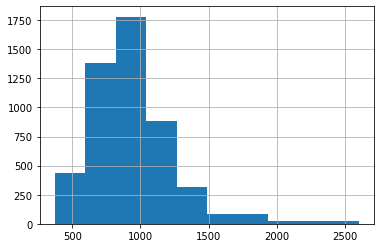

In [ ]:
dfdados['documentoOriginal'].apply(len).hist()

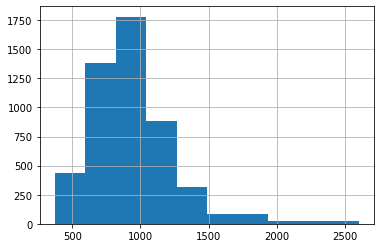

In [ ]:
dfdados['documentoPermutado'].apply(len).hist()

#### Descartando as documentos muito grandes

In [ ]:
# Tokenize a codifica os documentos para o BERT.     
dfdados['input_ids'] = dfdados['documentoOriginal'].apply(lambda tokens: tokenizer.encode(tokens, add_special_tokens=True))

# Reduz para o tamanho máximo suportado pelo BERT.
dfdados_512 = dfdados[dfdados['input_ids'].apply(len)<model_args.max_seq_len]

2021-04-15 20:00:25,074 : INFO : NumExpr defaulting to 2 threads.


In [ ]:
# Remove as colunas desnecessárias.
dfdadosAnterior = dfdados.drop(columns=['input_ids'])
dfdados = dfdados_512.drop(columns=['input_ids'])

In [ ]:
print('Quantidade de dados anterior: {}'.format(len(dfdadosAnterior)))
print('Nova quantidade de dados    : {}'.format(len(dfdados)))

Quantidade de dados anterior: 5020
Nova quantidade de dados    : 4980


In [ ]:
# Mostra a quantidade registros removidos
dfdadosSemLista =  dfdados.drop(columns=['sentencasOriginais','sentencasPermutadas'])
dfdados512SemLista =  dfdadosAnterior.drop(columns=['sentencasOriginais','sentencasPermutadas'])

df = dfdados512SemLista.merge(dfdadosSemLista, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
print('Quantidade de registros removidos: {}'.format(len(df)))

Quantidade de registros removidos: 40


In [ ]:
print(df)

             idOriginal  ...     _merge
2160  C33_Extrato_6.txt  ...  left_only
2161  C33_Extrato_6.txt  ...  left_only
2162  C33_Extrato_6.txt  ...  left_only
2163  C33_Extrato_6.txt  ...  left_only
2164  C33_Extrato_6.txt  ...  left_only
2165  C33_Extrato_6.txt  ...  left_only
2166  C33_Extrato_6.txt  ...  left_only
2167  C33_Extrato_6.txt  ...  left_only
2168  C33_Extrato_6.txt  ...  left_only
2169  C33_Extrato_6.txt  ...  left_only
2170  C33_Extrato_6.txt  ...  left_only
2171  C33_Extrato_6.txt  ...  left_only
2172  C33_Extrato_6.txt  ...  left_only
2173  C33_Extrato_6.txt  ...  left_only
2174  C33_Extrato_6.txt  ...  left_only
2175  C33_Extrato_6.txt  ...  left_only
2176  C33_Extrato_6.txt  ...  left_only
2177  C33_Extrato_6.txt  ...  left_only
2178  C33_Extrato_6.txt  ...  left_only
2179  C33_Extrato_6.txt  ...  left_only
3180   C3_Extrato_6.txt  ...  left_only
3181   C3_Extrato_6.txt  ...  left_only
3182   C3_Extrato_6.txt  ...  left_only
3183   C3_Extrato_6.txt  ...  left_only


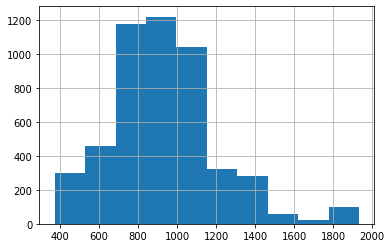

In [ ]:
dfdados_512['documentoOriginal'].apply(len).hist()

In [ ]:
# Mostra 5 linhas aleatórias dos dados
dfdados.sample(5)

,idOriginal,frasesOriginais,documentoOriginal,idPermutado,frasesPermutadas,documentoPermutado
2110,C44_Extrato_5.txt,[O Conselho de Ética do Senado vai decidir na ...,O Conselho de Ética do Senado vai decidir na p...,C44_Extrato_5_Perm_10.txt,[O Conselho de Ética do Senado vai decidir na ...,O Conselho de Ética do Senado vai decidir na p...
3426,C2_Extrato_4.txt,[O Instituto de pesquisa CNI/Ibope divulgou ne...,O Instituto de pesquisa CNI/Ibope divulgou nes...,C2_Extrato_4_Perm_6.txt,[A CNI explica que a pesquisa não traz a compa...,A CNI explica que a pesquisa não traz a compar...
2300,C48_Extrato_6.txt,[Duas horas antes da estréia da seleção brasil...,Duas horas antes da estréia da seleção brasile...,C48_Extrato_6_Perm_0.txt,[Alguns torcedores levaram seu protesto contra...,Alguns torcedores levaram seu protesto contra ...
42,C26_Extrato_1.txt,"[Os brasileiros que estão em Cancún, um dos po...","Os brasileiros que estão em Cancún, um dos pon...",C26_Extrato_1_Perm_2.txt,[Milhares de turistas assustados fizeram filas...,Milhares de turistas assustados fizeram filas ...
1913,C4_Extrato_4.txt,"[Depois de 20 dias de tempo seco, voltou a cho...","Depois de 20 dias de tempo seco, voltou a chov...",C4_Extrato_4_Perm_13.txt,"[Depois de 20 dias de tempo seco, voltou a cho...","Depois de 20 dias de tempo seco, voltou a chov..."


#### Procurando a maior quantidade de tokens no conjunto de dados

As células abaixo executará uma passagem de tokenização do conjunto de dados de treino, avaliação e teste para medir o comprimento máximo das documentos.

In [ ]:
maior_tamanho = 0

# Para cada documento no conjunto de treino.
for index, linha in dfdados_512.iterrows():        

    # Tokeniza o texto e adiciona os tokens `[CLS]` e `[SEP]`.
    input_ids = tokenizer.encode(linha['documentoOriginal'], add_special_tokens=True)

    # Atualiza o tamanho máximo de documento.
    maior_tamanho = max(maior_tamanho, len(input_ids))

print('Tamanho máximo de documento no conjunto de dados: {}'.format(maior_tamanho))

Tamanho máximo de documento no conjunto de dados: 467


## 6.3 Divisão em k folds

### 6.3.1 Realizando a divisão do conjunto de dados para treinamento e validação através do k folds

In [ ]:
# Import das bibliotecas.
import numpy as np
from sklearn.model_selection import KFold

# Cria o diretório para receber os folds
# Diretório a ser criado
dirbase = '/content/validacao_kfold'

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    print('Diretório criado: {}'.format(dirbase))
else:    
    print('Diretório já existe: {}'.format(dirbase))

# Parâmetros.
QTDE_FOLDS = model_args.fold

# Define o prefixo do nome dos arquivos dos folds
PREFIXO_NOME_ARQUIVO_TREINO = "/content/validacao_kfold/cstnews_md_train_f"
PREFIXO_NOME_ARQUIVO_TESTE = "/content/validacao_kfold/cstnews_md_test_f"

# Registra o tempo inícial.
t0 = time.time()

# Preparação do conjunto de dados.
X =  np.array(dfdados_512)

# Divisão em k folds(n_splits).
# shuffle, embaralha cada amostra.
# Quando shuffle igual True, random_state afeta a ordem dos índices,
# que controla a aleatoriedade de cada dobra.
kf = KFold(n_splits=QTDE_FOLDS,  random_state=True, shuffle=True)
print(kf)

TESTE = 1

# Percorre os indices do conjunto de dados.
for train_index, test_index in kf.split(X):
  print("\nExecutando divisão do fold: {}, Total: {}".format(TESTE, len(train_index)+len(test_index)))
  print("Treino: {}, Teste: {}".format(len(train_index), len(test_index)))

  #print("Índices de treino:", len(train_index), " - ", train_index[0], " - ", train_index[len(train_index)-1])  
  #print(train_index)
  #print("Índices de teste :", len(test_index), "  - ", test_index[0], " - ", test_index[len(test_index)-1])
  #print(test_index)

  # Recupera os dados das documentos para treino e teste.
  documentos_train = X[train_index]
  documentos_test  = X[test_index]  

  # Organiza dados de treino.
  documentos_train_organizada = []

  # Adiciona a documento incoerente logo após a coerente para treino.
  for linha in documentos_train:     
    # 1 para o documento original
    documentos_train_organizada.append((linha[0],linha[2],1))  
    # 0 para o documento permutado  
    documentos_train_organizada.append((linha[3],linha[5],0))
    
  # Cria um dataframe com os dados de treinamento.
  pddata_tuples_train = pd.DataFrame(documentos_train_organizada, columns=["id","documento","tipo"])
    
  # Salva o arquivo de treino do fold.
  pddata_tuples_train.to_csv(PREFIXO_NOME_ARQUIVO_TREINO + str(TESTE)+".csv", index = False, sep=';')

  # Organiza dados de teste.
  documentos_test_organizada = []

  # Adiciona a documento incoerente logo após a coerente para teste.
  for linha in documentos_test:    
    # 1 Para coerente.
    documentos_test_organizada.append((linha[0],linha[2],1))
    # 0 para uma permutação como incoerente.
    documentos_test_organizada.append((linha[3],linha[5],0))
    
  # Cria um dataframe com os dados de teste.
  pddata_tuples_test = pd.DataFrame(documentos_test_organizada, columns=["id","documento","tipo"])  
  
  # Salva o arquivo de teste do fold.
  pddata_tuples_test.to_csv(PREFIXO_NOME_ARQUIVO_TESTE+str(TESTE)+".csv", index = False, sep=';')

  # Avança o contador de testes.
  TESTE = TESTE + 1

# Medida de quanto tempo levou a execução da validação.
teste_time = formataTempo(time.time() - t0)

print("  Tempo gasto: {:}".format(teste_time))

Diretório criado: /content/crossvalidation
KFold(n_splits=10, random_state=True, shuffle=True)

Executando divisão do fold: 1, Total: 4980
Treino: 4482, Teste: 498

Executando divisão do fold: 2, Total: 4980
Treino: 4482, Teste: 498

Executando divisão do fold: 3, Total: 4980
Treino: 4482, Teste: 498

Executando divisão do fold: 4, Total: 4980
Treino: 4482, Teste: 498

Executando divisão do fold: 5, Total: 4980
Treino: 4482, Teste: 498

Executando divisão do fold: 6, Total: 4980
Treino: 4482, Teste: 498

Executando divisão do fold: 7, Total: 4980
Treino: 4482, Teste: 498

Executando divisão do fold: 8, Total: 4980
Treino: 4482, Teste: 498

Executando divisão do fold: 9, Total: 4980
Treino: 4482, Teste: 498

Executando divisão do fold: 10, Total: 4980
Treino: 4482, Teste: 498
  Tempo gasto: 0:00:03


### 6.3.2 Analisando os dados gerados na divisão

In [ ]:
# Lista para armazenar os dados
lista_dadostrain_folds = []
lista_dadostest_folds = []

# Define o prefixo do nome dos arquivos dos folds
PREFIXO_NOME_ARQUIVO_TREINO = "/content/validacao_kfold/cstnews_md_train_f"
PREFIXO_NOME_ARQUIVO_TESTE = "/content/validacao_kfold/cstnews_md_test_f"

for x in range(QTDE_FOLDS):
  
  dadostrain = pd.read_csv(PREFIXO_NOME_ARQUIVO_TREINO+str(x+1)+".csv", sep=';')
  print('Dados treino do fold {}: {}'.format(x+1,len(dadostrain)))

  dadostest = pd.read_csv(PREFIXO_NOME_ARQUIVO_TESTE+str(x+1)+".csv", sep=';')
  print('Dados teste do fold {}: {}'.format(x+1,len(dadostest)))

  lista_dadostrain_folds.append([x,dadostrain.tipo.sum(), len(dadostrain.tipo)-dadostrain.tipo.sum()])
  lista_dadostest_folds.append([x,dadostest.tipo.sum(), len(dadostest.tipo)-dadostest.tipo.sum()])

  # Pega as listas de documentos e seus rótulos.
  documentos = dadostrain.documento.values
  maior_tamanho_documento_treino = 0
  # Para cada documento no conjunto de treino.
  for documento in documentos:
    # Tokeniza o texto e adiciona os tokens `[CLS]` e `[SEP]`.
    input_ids = tokenizer.encode(documento, add_special_tokens=True)
    # Atualiza o tamanho máximo de documento.
    maior_tamanho_documento_treino = max(maior_tamanho_documento_treino, len(input_ids))
  print('Máximo de tokens no conjunto de dados de treino: {}'.format(maior_tamanho_documento_treino))

  # Pega as listas de documentos e seus rótulos.
  documentos = dadostest.documento.values
  maior_tamanho_documento_teste = 0    
  # Para cada documento no conjunto de treino.  
  for documento in documentos:
    # Tokeniza o texto e adiciona os tokens `[CLS]` e `[SEP]`.
    input_ids = tokenizer.encode(documento, add_special_tokens=True)
    # Atualiza o tamanho máximo de documento.
    maior_tamanho_documento_teste = max(maior_tamanho_documento_teste, len(input_ids))
  print('Máximo de token no conjunto de dados de teste: {}'.format(maior_tamanho_documento_teste))
                               
  print('Fold {} Treino positivos: {} of {} ({:.2f}%)'.format(x+1, 
                                                             dadostrain.tipo.sum(), 
                                                             len(dadostrain.tipo), 
                                                             (dadostrain.tipo.sum() / len(dadostrain.tipo) * 100.0)
                                                             ))
  
  print('Fold {} Treino negativos: {} of {} ({:.2f}%)'.format(x+1, 
                                                             len(dadostrain.tipo)-dadostrain.tipo.sum(), 
                                                             len(dadostrain.tipo), 
                                                             ((len(dadostrain.tipo)-dadostrain.tipo.sum()) / len(dadostrain.tipo) * 100.0)))

  print('Fold {} Teste positivos: {} of {} ({:.2f}%)'.format(x+1, 
                                                             dadostest.tipo.sum(), 
                                                             len(dadostest.tipo), 
                                                             (dadostest.tipo.sum() / len(dadostest.tipo) * 100.0)))
  print('Fold {} Teste negativos: {} of {} ({:.2f}%)'.format(x+1, 
                                                             len(dadostest.tipo)-dadostest.tipo.sum(), 
                                                             len(dadostest.tipo), 
                                                             ((len(dadostest.tipo)-dadostest.tipo.sum()) / len(dadostest.tipo) * 100.0)))                               
  print('')


Dados treino do fold 1: 8964
Dados teste do fold 1: 996
Máximo de tokens no conjunto de dados de treino: 467
Máximo de token no conjunto de dados de teste: 467
Fold 1 Treino positivos: 4482 of 8964 (50.00%)
Fold 1 Treino negativos: 4482 of 8964 (50.00%)
Fold 1 Teste positivos: 498 of 996 (50.00%)
Fold 1 Teste negativos: 498 of 996 (50.00%)

Dados treino do fold 2: 8964
Dados teste do fold 2: 996
Máximo de tokens no conjunto de dados de treino: 467
Máximo de token no conjunto de dados de teste: 467
Fold 2 Treino positivos: 4482 of 8964 (50.00%)
Fold 2 Treino negativos: 4482 of 8964 (50.00%)
Fold 2 Teste positivos: 498 of 996 (50.00%)
Fold 2 Teste negativos: 498 of 996 (50.00%)

Dados treino do fold 3: 8964
Dados teste do fold 3: 996
Máximo de tokens no conjunto de dados de treino: 467
Máximo de token no conjunto de dados de teste: 467
Fold 3 Treino positivos: 4482 of 8964 (50.00%)
Fold 3 Treino negativos: 4482 of 8964 (50.00%)
Fold 3 Teste positivos: 498 of 996 (50.00%)
Fold 3 Teste neg

### 6.3.3 Compacta e copia os arquivos do fold para o GoogleDrive

In [ ]:
#!cp '/content/validacao_kfold/'cstnews_*.* '/content/drive/My Drive/Colab Notebooks/Data/CSTNEWS/validacao_kfold'

print("Terminei a cópia!")

Terminei a cópia!


Compacta os arquivos em dos folds

A opção `-jr` do zip compacta os arquivos ignorando a estrutura de diretório.

In [ ]:
!zip -jr '/content/validacao_kfold/'CSTNEWS_MD_KFOLD_10.zip 'validacao_kfold/'cstnews_*.*

print("Terminei a compactação!")

  adding: crossvalidation/cstnews_md_test_f10.csv (deflated 89%)
  adding: crossvalidation/cstnews_md_test_f1.csv (deflated 89%)
  adding: crossvalidation/cstnews_md_test_f2.csv (deflated 89%)
  adding: crossvalidation/cstnews_md_test_f3.csv (deflated 89%)
  adding: crossvalidation/cstnews_md_test_f4.csv (deflated 89%)
  adding: crossvalidation/cstnews_md_test_f5.csv (deflated 89%)
  adding: crossvalidation/cstnews_md_test_f6.csv (deflated 89%)
  adding: crossvalidation/cstnews_md_test_f7.csv (deflated 89%)
  adding: crossvalidation/cstnews_md_test_f8.csv (deflated 89%)
  adding: crossvalidation/cstnews_md_test_f9.csv (deflated 89%)
  adding: crossvalidation/cstnews_md_train_f10.csv (deflated 97%)
  adding: crossvalidation/cstnews_md_train_f1.csv (deflated 97%)
  adding: crossvalidation/cstnews_md_train_f2.csv (deflated 97%)
  adding: crossvalidation/cstnews_md_train_f3.csv (deflated 97%)
  adding: crossvalidation/cstnews_md_train_f4.csv (deflated 97%)
  adding: crossvalidation/cstnews

Copia o arquivo compactado para o google drive

In [ ]:
#!cp '/content/validacao_kfold/'CSTNEWS_MD_KFOLD_10.zip '/content/drive/My Drive/Colab Notebooks/Data/CSTNEWS/validacao_kfold'

print("Terminei a cópia!")

Terminei a cópia!


# Tempo final de processamento



In [ ]:
 # Pega o tempo atual menos o tempo do início do processamento.
finalProcessamento = time.time()
tempoTotalProcessamento = formataTempo(finalProcessamento - inicioProcessamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempoTotalProcessamento))


  Tempo processamento:  0:09:04 (h:mm:ss)
